In [1]:
import os 
os.chdir("..")
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *

In [78]:
import matplotlib as mpl
label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


In [2]:
itraj = 1

total_time = 4
dt = 1e-6

In [3]:
times = np.arange(0,total_time + dt, dt)

pars = give_def_params_discrimination(flip=0) ## H0 is the true hypothesis
params, exp_path = check_params(pars)

logliks =load_data_discrimination_liks(itraj=itraj, total_time = total_time, dt=dt, exp_path = exp_path)
l0,l1 = logliks[:,0], logliks[:,1]
log_lik_ratio = l1 - l0  ###

logliks_swap =load_data_discrimination_liks(itraj=itraj, total_time = 4, dt=1e-6, exp_path = exp_path)
### logliks ---> p(yt | \thetaNull)  , p(yt | thetaTrue )

#### for the other hypothesis, flip the parameters
pars = give_def_params_discrimination(flip=1)
params, exp_path = check_params(pars)
### now we want to see the p(H1 | H0) ---> check how many times we'd guess for h1 if data generated by h0 at stopping time
log_lik_ratio_swap = logliks[:,0] - logliks[:,1]  ### since i swapped the parameters, this gives p(y_t | h1)/p(y_t | h0)   (now in the case where i generate y_t under h0)


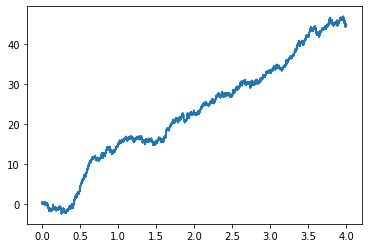

In [4]:
plt.plot(times,log_lik_ratio[:-1])

In [5]:
def load_liks(itrajj):
    pars = give_def_params_discrimination(flip=0)
    params, exp_path = check_params(pars)

    logliks =load_data_discrimination_liks(itraj=itrajj, total_time = total_time, dt=dt, exp_path = exp_path)
    l0,l1 = logliks[:,0], logliks[:,1]
    log_lik_ratio = l1 - l0  ###

    
    pars = give_def_params_discrimination(flip=1)
    params, exp_path = check_params(pars)
    logliks_swap =load_data_discrimination_liks(itraj=itrajj, total_time = 4, dt=1e-6, exp_path = exp_path)

    log_lik_ratio_swap = logliks[:,0] - logliks[:,1]  
    
    return log_lik_ratio, log_lik_ratio_swap

In [72]:
indis = np.logspace(2,np.log10(len(times)), 10)
indis = [int(k) for k in indis]

In [82]:
-1<a<0

False

In [85]:
def decide_stop(l, a, b):
    if a<=l<=b:
        return 0
    else:
        return 1

In [86]:
deter, stoch = {}, {}
deter["h0/h1"]  = []
deter["h1/h0"] = []
stoch["h1/h0"] = {}
stoch["h0/h1"] = {}

boundsB = np.arange(1,2,1)
boundsA = np.sort(-boundsB)[::-1]
for ind_bound in range(len(boundsB)):
    stoch["h0/h1"][ind_bound] = []
    stoch["h1/h0"][ind_bound] = []    

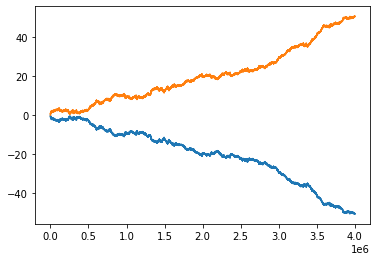

In [87]:
plt.plot(log_lik_ratio_swap)
plt.plot(log_lik_ratio)

In [88]:
itraj = 1
log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)

for time_index in tqdm(indis):
    h0_deter = log_lik_ratio[time_index] <= 0
    h1_deter = log_lik_ratio_swap[time_index] <= 0
    deter["h0/h1"].append(int(h0_deter))
    deter["h1/h0"].append(int(h0_deter))
    for ind_bound, a, b in zip(range(len(boundsB)), boundsA, boundsB):
        stoch["h0/h1"][ind_bound].append(decide_stop(log_lik_ratio[time_index], a, b))
        stoch["h1/h0"][ind_bound].append(decide_stop(log_lik_ratio_swap[time_index], a, b))
n=1

100%|██████████| 10/10 [00:00<00:00, 14488.10it/s]


In [146]:
for itraj in tqdm(range(2,1000)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj)
        n+=1
        for ind, time_index in enumerate(indis):
            h0_deter = log_lik_ratio[time_index] <= 0
            h1_deter = log_lik_ratio_swap[time_index] <= 0
            deter["h0/h1"][ind] +=  (int(h0_deter) - deter["h0/h1"][ind] )/n
            deter["h1/h0"][ind] += (int(h0_deter) - deter["h1/h0"][ind])/n
            #for ind_bound, a, b in zip(range(len(boundsB)), boundsA, boundsB):
            #    stoch["h0/h1"][ind_bound][ind] += (decide_stop(log_lik_ratio[time_index], a, b) - stoch["h0/h1"][ind_bound][ind])/n
            #    stoch["h1/h0"][ind_bound][ind] += (decide_stop(log_lik_ratio_swap[time_index], a, b) - stoch["h1/h0"][ind_bound][ind])/n
    except Exception:
        pass

 12%|█▏        | 115/998 [00:52<06:45,  2.18it/s]


KeyboardInterrupt: 

In [ ]:
ht_dir = get_def_path()+"hypothesis_testing/set1_1/"
os.makedirs(ht_dir, exist_ok=True)
np.save(ht_dir+"deter_alpha", deter["h0/h1"])
np.save(ht_dir+"deter_beta", deter["h1/h0"])
#np.save(ht_dir+"stoch_alpha_stop", np.stack(list(stoch["h0/h1"].values())))
#np.save(ht_dir+"stoch_beta_stop", np.stack(list(stoch["h1/h0"].values())))
np.save(ht_dir+"bounds", boundsB)
np.save(ht_dir+"times", times)
np.save(ht_dir+"ind_times_computed", indis)

In [ ]:
def avg_stop_time_sprt(b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1):
    Su1 = n1 + 0.5 + (kappa1 / gamma1)
    Su0 = n0 + 0.5 + (kappa0 / gamma0)

    S1 = (np.sqrt(1 + (16.0*eta1*kappa1*Su1/gamma1)) - 1)*(gamma1/(8.0*eta1*kappa1))
    S0 = (np.sqrt(1 + (16.0*eta0*kappa0*Su0/gamma0)) - 1)*( gamma0/(8.0*eta0*kappa0))

    lam = gamma0 + (8*eta0*kappa0*S0)

    aa = (4*eta1*kappa1*(S1**2))/gamma1
    bb =(4*eta0*kappa0*S0**2)*(1+((16.0*eta1*kappa1*S1)/ (gamma1 + lam)) + (64.0*(eta1 * kappa1 * S1)**(2)/(gamma1 * (gamma1 + lam))))/ lam
    c =8 *(S0*S1*(eta0*kappa0 *eta1*kappa1)**(0.5)) * (gamma1+ (4.0*eta1*kappa1*S1) ) / ((gamma1 + lam)*gamma1)

    mu = 4*(eta1*kappa1*aa + (eta0*kappa0*bb) - 2*np.sqrt(eta1*kappa1*eta0*kappa0)*c)
    
    return  abs(b)/(4*mu)

In [143]:
pars = give_def_params_discrimination(flip=0) ## H0 is the true hypothesis
params, exp_path = check_params(pars)

[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

In [145]:
avg_stop_time_sprt(3, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)

0.07100525710904844

In [160]:
deter["h0/h1"] =  np.load(get_def_path()+"hypothesis_testing/set1/deter_alpha.npy")
deter["h1/h0"] =  np.load(get_def_path()+"hypothesis_testing/set1/deter_beta.npy")
indis =  np.load(get_def_path()+"hypothesis_testing/set1/ind_times_computed.npy")

In [199]:
my impression is that this is estimated (i'm u[avg_err_alpha(b) for b in np.arange(1,10,1)]

[0.26894142136999516,
 0.11920292202211755,
 0.047425873177566774,
 0.01798620996209156,
 0.006692850924284856,
 0.0024726231566347743,
 0.0009110511944006455,
 0.0003353501304664781,
 0.00012339457598623172]

Text(0, 0.5, 'errors')

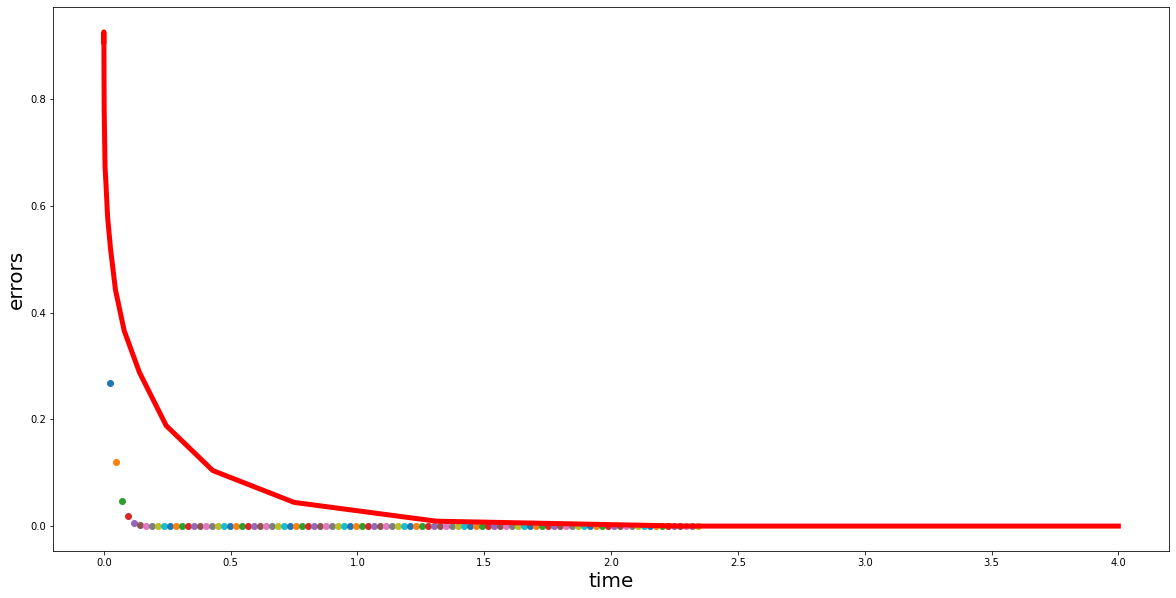

In [201]:
lstoch=10
ldet = 5

ep = lambda k: 1/(1+np.exp(k))
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.plot([times[ind] for ind in indis], 0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]), linewidth=ldet, color="red", label=r'$\frac{1}{2}( \alpha + \beta)$' +"(deter)")
#ax.set_xticks(size=16)
#ax.set_yticks(size=16)
#ax.axhline(y=ep(b), label=r'$\epsilon_1$'+" = {}".format(np.round(ep(b),2)))
for b in np.arange(1,100,1):
    #ax.scatter(x=[b/(4*mu)], y=[ep(b)], label=r'$\epsilon_1$'+" = {}".format(np.round(ep(b),2)))
    ax.scatter(x=[b/(4*mu)], y=[avg_err_alpha(b)], label=r'$P_{err}^{stoch}$'+" = {}".format(np.round(ep(b),2)))
    #[np.exp(-b)/(np.exp(b) - np.exp(-b))]

ax.set_xlabel("time", size=20)
ax.set_ylabel("errors", size=20)
#ax.legend(prop={"size":30})
#plt.savefig("avg_errs.pdf")

In [221]:
np.argmin(np.abs(np.array(deter["h0/h1"]) - b))

2

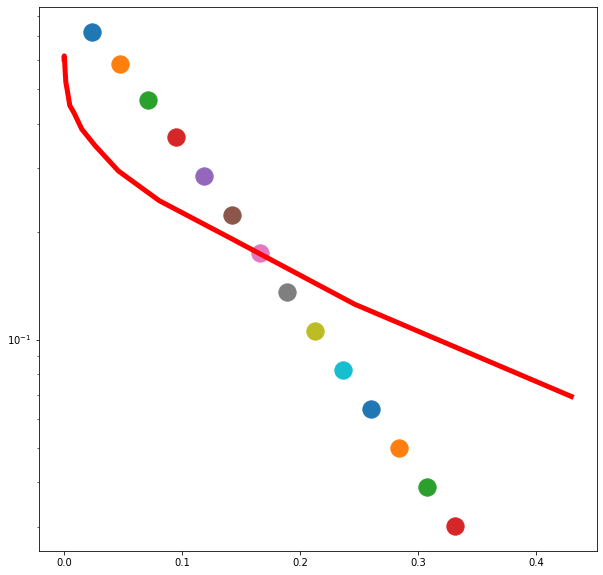

In [220]:
plt.figure(figsize=(10,10))
M=16
ax = plt.subplot(111)
for b in np.arange(1,15,1):
    ax.scatter(x=[b/(4*mu)], y=[avg_err_alpha(b)**(1/4)], s=300,label=r'$P_{err}^{stoch}$'+" = {}".format(np.round(ep(b),2)))
ax.plot([times[ind] for ind in indis[:M]], np.array(deter["h0/h1"][:M]), linewidth=ldet, color="red", label=r'$\frac{1}{2}( \alpha + \beta)$' +"(deter)")
ax.set_yscale("log")

In [223]:
from scipy.special import erf

In [241]:
times_ind = [times[ii] for ii in indis]
alph = np.array([0.5*(1 + erf(np.sqrt(mu*t)/(2))) for t in times_ind])
#alph0 = [0.5*(1 + erf(mu*t/(2*np.sqrt(mu*t)))) for t in times_ind]

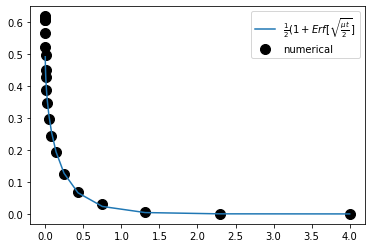

In [253]:
plt.plot(times_ind,1-alph, label=r'$\frac{1}{2} ( 1+ Erf[\sqrt{\frac{\mu t}{2}}]$')
plt.scatter(times_ind, np.array(deter["h0/h1"]), s=100, color="black", label="numerical")
plt.legend()

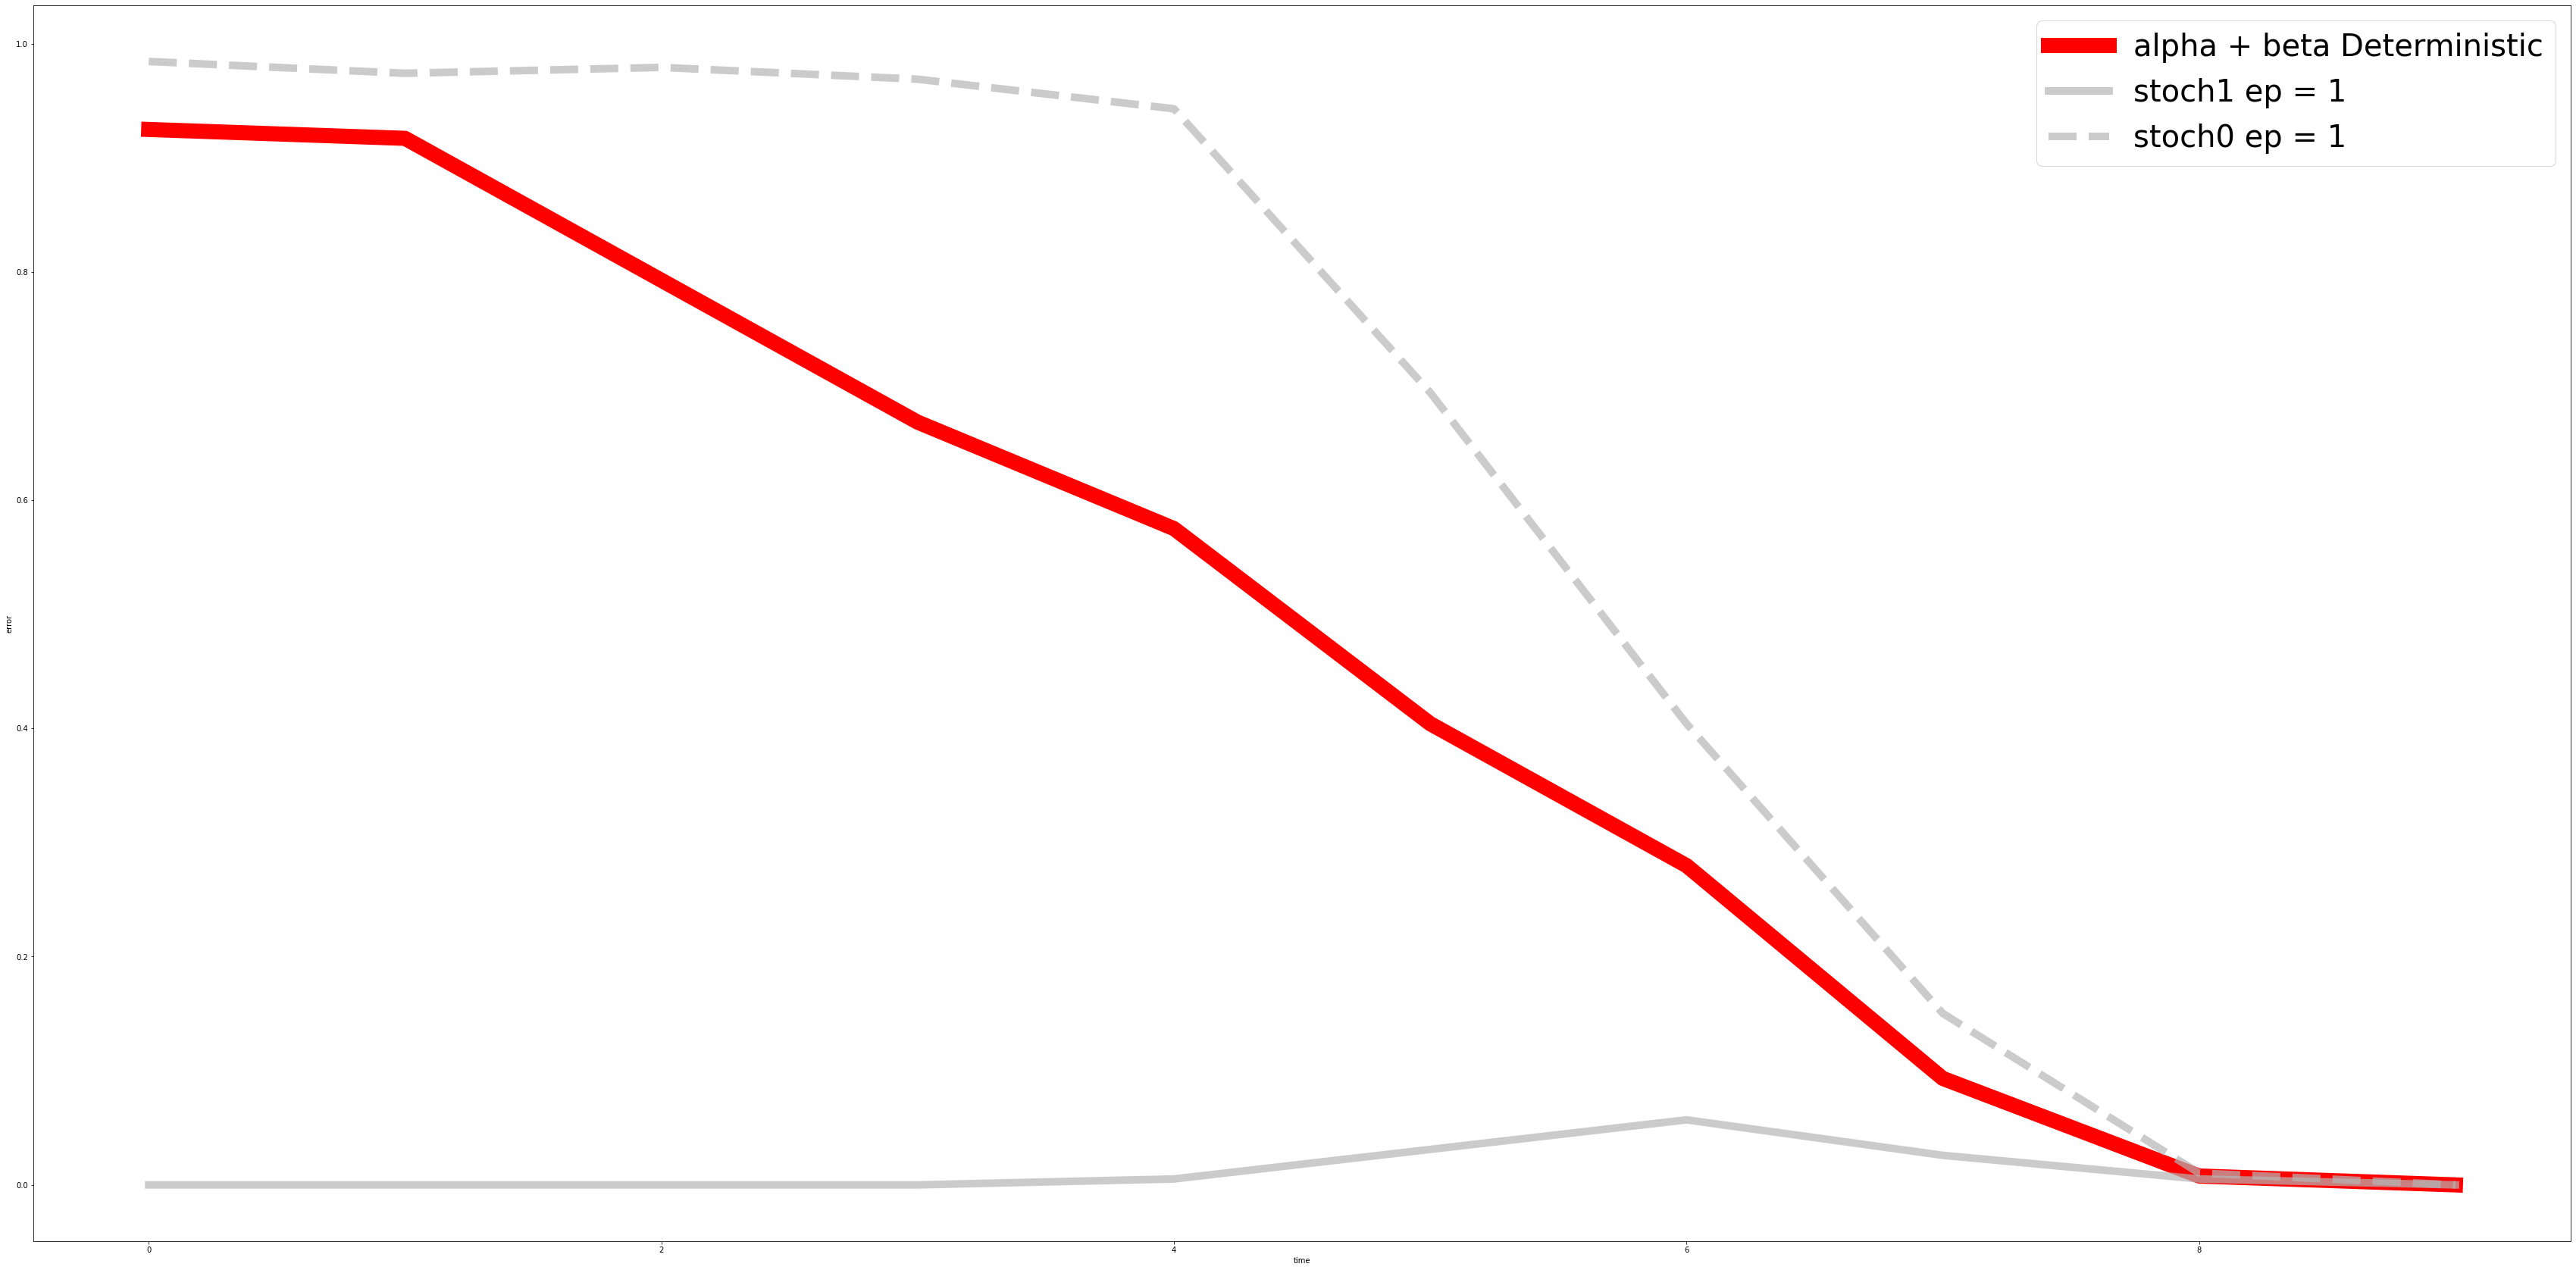

In [80]:


lstoch=10
ldet = 10

plt.figure(figsize=(60,30))
plt.plot(0.5*np.array(deter["h0/h1"])+np.array(deter["h1/h0"]), linewidth=2*ldet, color="red", label="alpha + beta Deterministic")
#plt.plot(deter["h1/h0"], linewidth=ldet,color="blue", label="beta")


#colors = plt.get_cmap("Greys")
#mybounds = list(range(len(boundsB)))[::10][:2]
#indiis = np.linspace(.4,.8,len(mybounds))

#colores = colors(indiis)
#for ii, ind_bound in enumerate(mybounds):
#    plt.plot(np.real(stoch["h0/h1"][ind_bound]), linewidth=lstoch, c=colores[ii], alpha=0.7,label="stoch1 ep = {}".format(np.round(boundsB[ind_bound],2)))
#    plt.plot(1-np.real(stoch["h1/h0"][ind_bound]),'--', linewidth=lstoch,c=colores[ii],alpha=0.7,label="stoch0 ep = {}".format(np.round(boundsB[ind_bound],2)))
    #plt.plot(np.imag(stoch["h0/h1"][ind_bound]), '.-',linewit's supucious that it's supucious that it's supucious that idth=lstoch,c="black", alpha=0.7,label="stoch1 waiting ep = {}".format(np.round(boundsB[ind_bound],2)))
    #plt.plot(np.imag(stoch["h1/h0"][ind_bound]), '.',linewidth=lstoch,c="black", alpha=0.7,label="stoch0 waiting ep = {}".format(np.round(boundsB[ind_bound],2)))
    
plt.ylabel("error")
plt.xlabel("time")
plt.legend(prop={"size":40})
#plt.savefig("deter_errors.pdf")

In [117]:
deter, stoch = {}, {}
deter["h0/h1"]  = []
deter["h1/h0"] = []
stoch["h1/h0"] = {}
stoch["h0/h1"] = {}

boundsB = np.arange(1,10.1,.1)
boundsA = np.sort(-boundsB)[::-1]
for ind_bound in range(len(boundsB)):
    stoch["h0/h1"][ind_bound] = []
    stoch["h1/h0"][ind_bound] = []    
    
deter["h0/h1"] = np.load(ht_dir+"deter_alpha.npy")
deter["h1/h0"] = np.load(ht_dir+"deter_beta.npy")
stochh0h1_stacked = np.load(ht_dir+"stoch_alpha.npy")
stochh1h0_stacked = np.load(ht_dir+"stoch_beta.npy")


for k, b in enumerate(boundsB):
    stoch["h0/h1"][k] = stochh0h1_stacked[k,:]
    stoch["h1/h0"][k] = stochh1h0_stacked[k,:]

(1+1j)

In [116]:
stoch["h0/h1"][2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

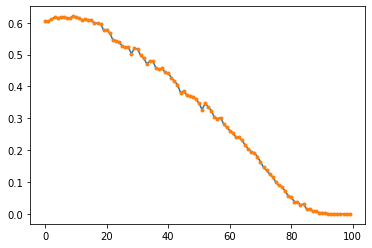

In [113]:
plt.plot(deter["h0/h1"])
plt.plot(deter["h1/h0"],'.')

In [100]:
plt.plot(deter["h0/h1"])
np.real(stoch["h1/h0"][ind_bound])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
#[times[int(k)] for k in indis]

In [ ]:


### stand up at the equal likelihood point ---> you choose max-likelihood hypothesis!
h0 = log_lik_ratio[ind_time_sprt_avg_stop_time] <= 0
h0_sprt = log_lik_ratio[ind_time_sprt_avg_stop_time] <= -3

sprt_errs["h0/h1"].append(int(h0_sprt))
np_errs["h0/h1"].append(int(h0))


### stand up at the equal likelihood point ---> you choose max-likelihood hypothesis!
h1 = log_lik_ratio_swap[ind_time_sprt_avg_stop_time] >= 0
h1_sprt = log_lik_ratio_swap[ind_time_sprt_avg_stop_time] >= 3

np_errs["h1/h0"].append(int(h1))
sprt_errs["h1/h0"].append(int(h1_sprt))
